In [1]:
library(tidyverse)

library(grid)
library(gridExtra)

source("/home/yuliya/repos/other/removeBatch/evaluation_utils/plots_eda.R")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Warning message:
“package ‘ggsci’ was built under R version 4.3.3”


# Load data

In [2]:
data_path <- "/home/yuliya/repos/other/removeBatch/evaluation_data/microarray/"


central_corrected <- read.csv(paste0(data_path, "after/central_corrected.tsv"), sep = "\t", header = TRUE, row.names = 1, check.names = F)
central_uncorrected <- read.csv(paste0(data_path, "before/all_expression.tsv"), sep = "\t", header = TRUE, row.names = 1, check.names = F)
metadata <- read.csv(paste0(data_path, "before/all_metadata.tsv"), sep = "\t", header = TRUE, row.names = 1)

# remove X from row names
rownames(metadata) <- gsub("X", "", rownames(metadata))
metadata$file <- rownames(metadata)
# order the columns in intensity dataframes
central_corrected <- central_corrected[, rownames(metadata)]
central_uncorrected <- central_uncorrected[, rownames(metadata)]

cat("Loaded data")
cat("Central corrected:", nrow(central_corrected), "rows\n")
cat("Central uncorrected:", nrow(central_uncorrected), "rows\n")
cat("Sample metadata:", nrow(metadata), "rows\n\n")



Loaded dataCentral corrected: 21128 rows
Central uncorrected: 21128 rows
Sample metadata: 408 rows



# Checks

## Diagnostic plots

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”


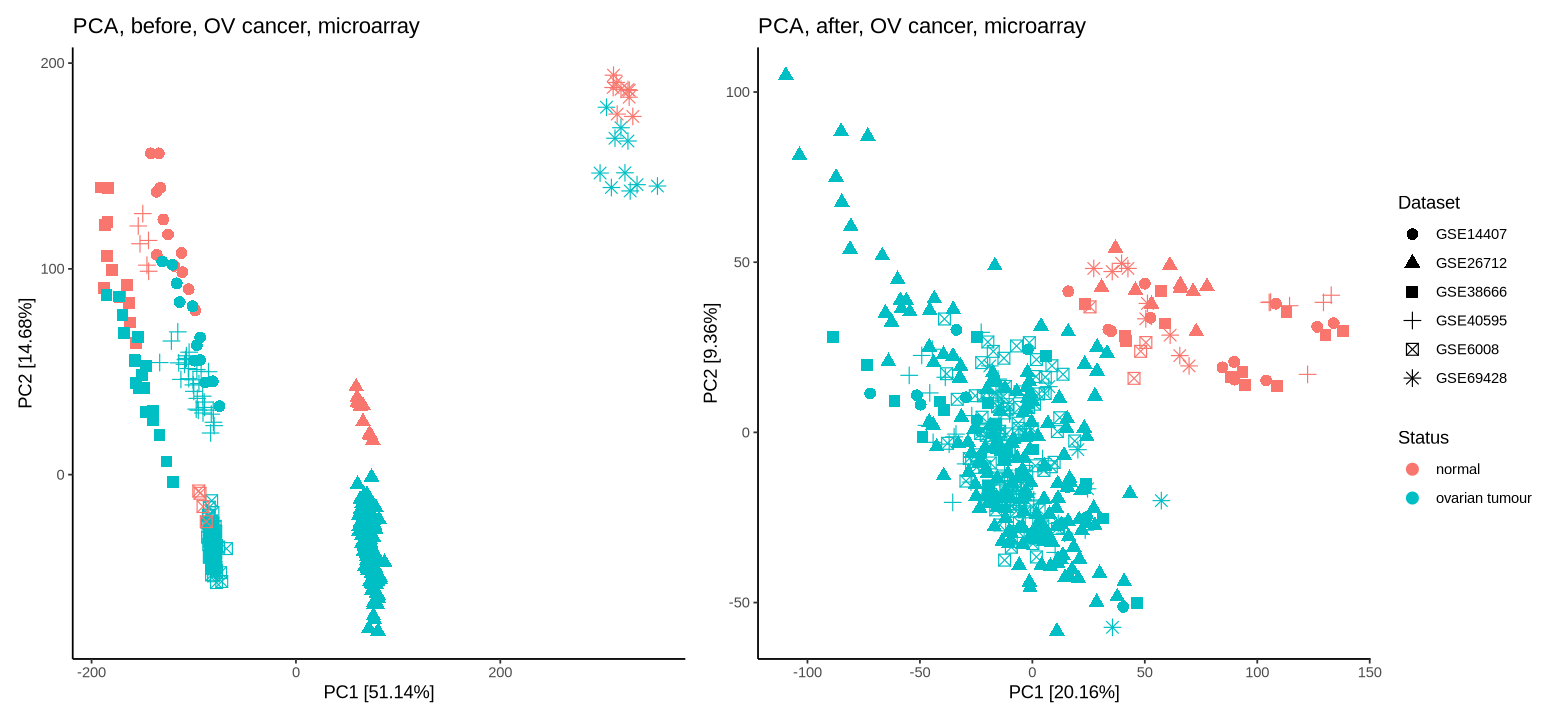

In [3]:
pca_plot_uncorrected <- pca_plot(central_uncorrected, metadata, 
    title = paste("PCA, before, OV cancer, microarray"),
    quantitative_col_name = "file", col_col = "Status", shape_col="Dataset", show_legend=F)
pca_plot_corrected <- pca_plot(central_corrected, metadata, 
    title = paste("PCA, after, OV cancer, microarray"),
    quantitative_col_name = "file", col_col = "Status", shape_col="Dataset", show_legend=T)

layout <- (pca_plot_uncorrected + pca_plot_corrected)

options(repr.plot.width=13, repr.plot.height=6)
layout

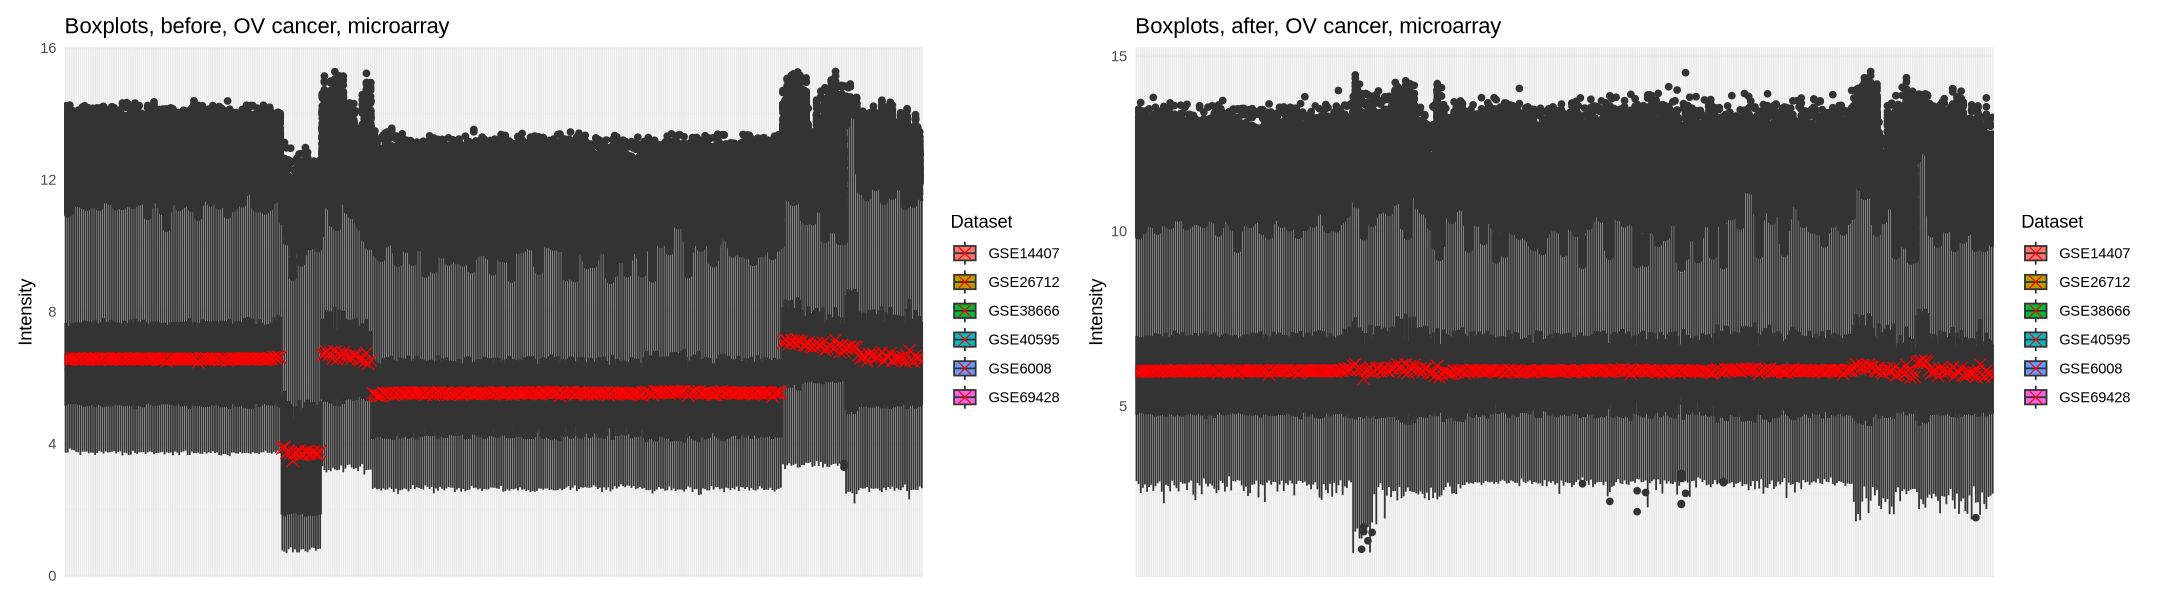

In [4]:
# sample 7000 rows for boxplots
sample_cor <- central_corrected[sample(1:nrow(central_corrected), 7000),]
sample_uncor <- central_uncorrected[sample(1:nrow(central_uncorrected), 7000),]

boxplots_uncorrected <- boxplot_plot(sample_uncor, metadata,
    title = paste("Boxplots, before, OV cancer, microarray"),
    quantitativeColumnName = "file",
    color_col = "Dataset", remove_xnames = T)
boxplots_corrected <- boxplot_plot(sample_cor, metadata, 
    title = paste("Boxplots, after, OV cancer, microarray"),
    quantitativeColumnName = "file",
    color_col = "Dataset", remove_xnames = T)


options(repr.plot.width=18, repr.plot.height=5)
layout

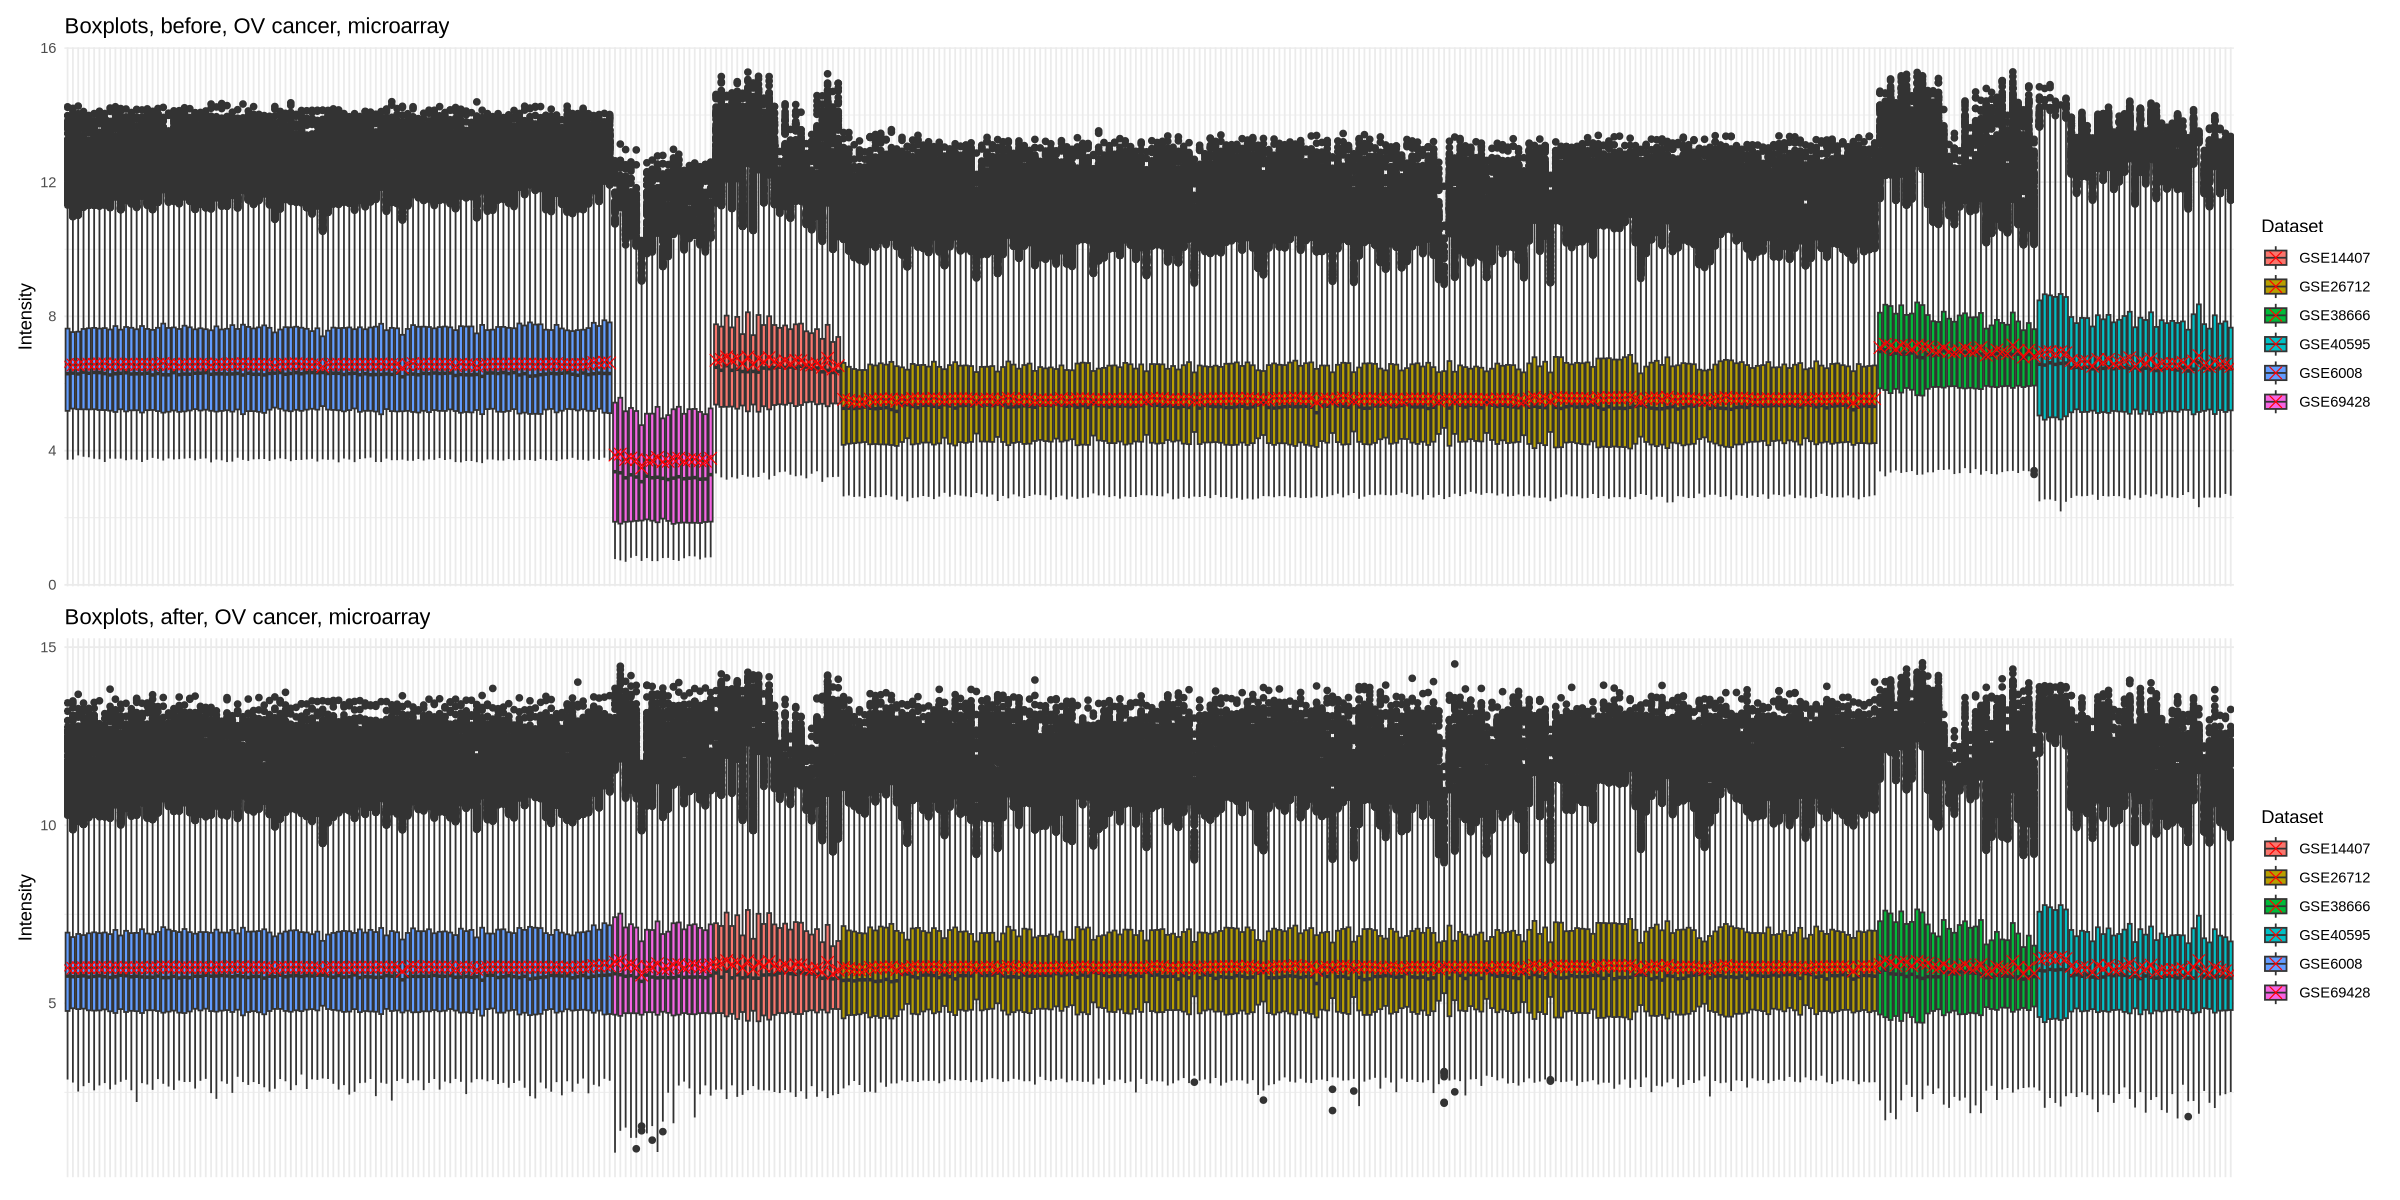

In [7]:

layout <- boxplots_uncorrected  /
            boxplots_corrected

options(repr.plot.width=20, repr.plot.height=10)
layout

No id variables; using all as measure variables

No id variables; using all as measure variables



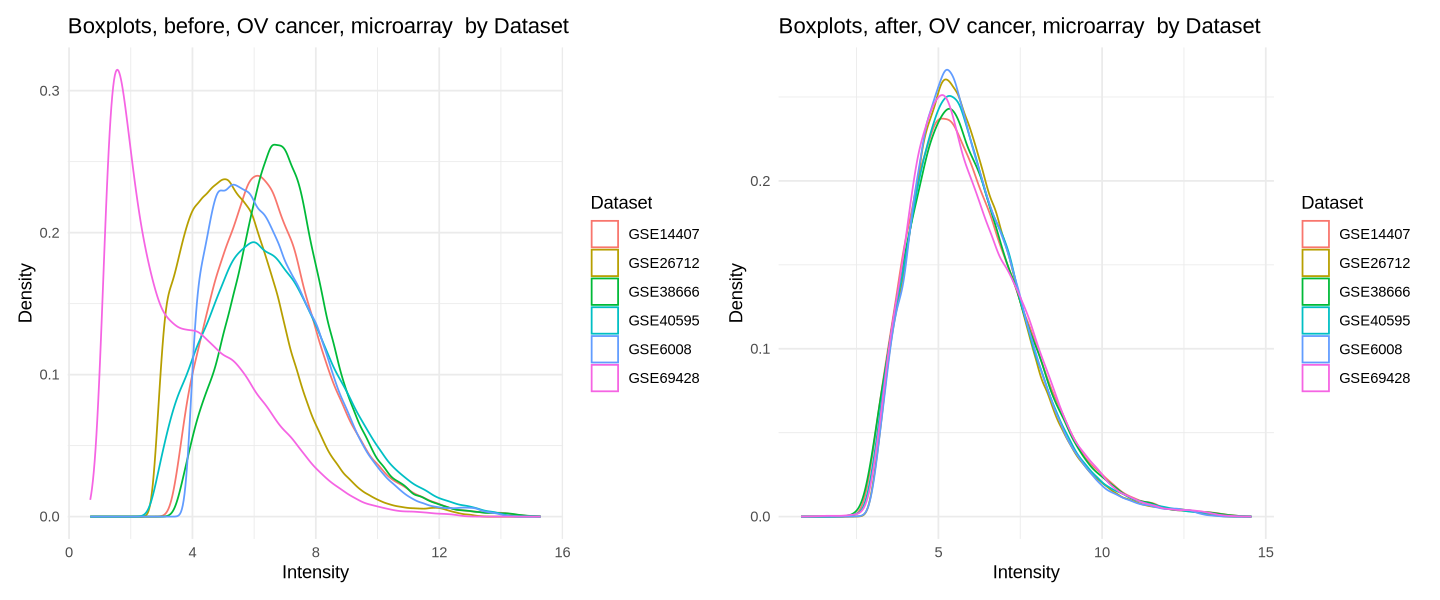

In [9]:
density_plots_uncorrected <- plotIntensityDensity(sample_uncor, metadata, 
    title = paste("Boxplots, before, OV cancer, microarray"),
    quantitativeColumnName = "file",
    colorColumnName = "Dataset")
density_plots_corrected <- plotIntensityDensity(sample_cor, metadata, 
    title = paste("Boxplots, after, OV cancer, microarray"),
    quantitativeColumnName = "file",
    colorColumnName = "Dataset")

layout <- (density_plots_uncorrected + density_plots_corrected) 

options(repr.plot.width=12, repr.plot.height=5)
layout


##  Linear model per variable

Following batch effect correction, the percentage of variance explained by the condition should be greater than the batch.

In [10]:
library(variancePartition)

Loading required package: limma

Loading required package: BiocParallel


Attaching package: ‘variancePartition’


The following object is masked from ‘package:limma’:

    topTable




In [11]:
lmpv_plot <- function(data, metadata, title){
    form <- ~ Status + Dataset

    varPart <- fitExtractVarPartModel(na.omit(data), form, metadata)
    variance_col <- as.matrix(varPart[,1:2])

    df_long <- reshape2::melt(variance_col)

    # Plotting the boxplots using ggplot2
    ggplot(df_long, aes(x = Var2, y = value, fill=Var2)) +
      geom_boxplot() +
      labs(title = title,
           y = "Proportion Variance", x = "Column") +
          scale_fill_discrete(name = "Column") +
      theme_minimal()
}

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack



Total:84 s


Total:87 s



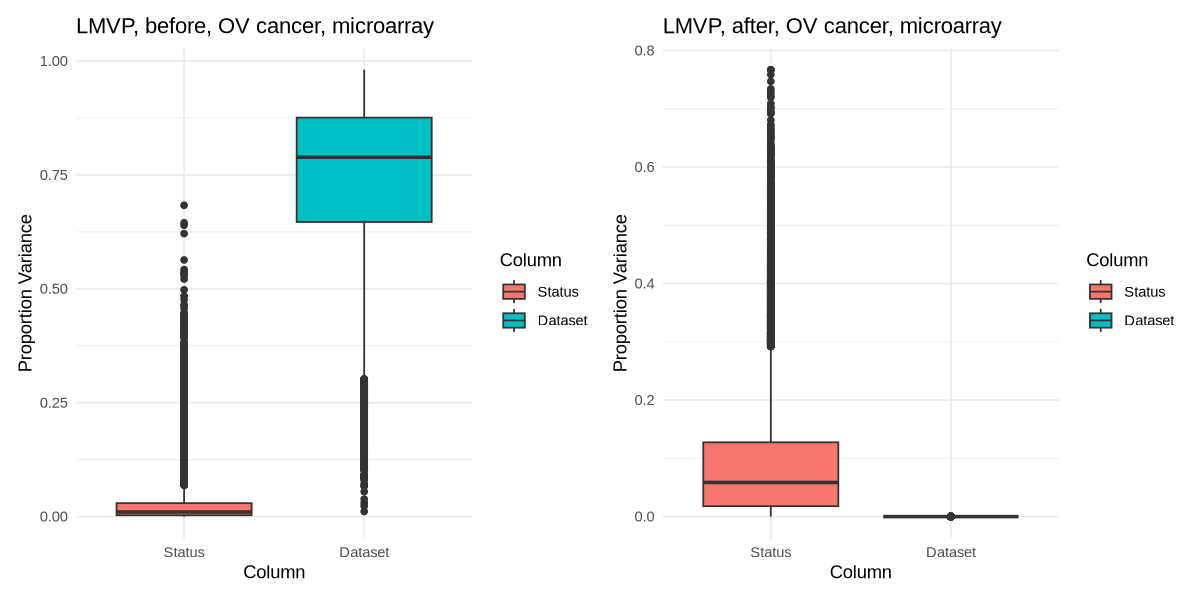

In [12]:

lmpv_plots_corrected <- lmpv_plot(central_corrected, metadata, 
    title = paste("LMVP, after, OV cancer, microarray"))
lmpv_plot_uncorrected <- lmpv_plot(central_uncorrected, metadata, 
    title = paste("LMVP, before, OV cancer, microarray"))


layout <- (lmpv_plot_uncorrected + lmpv_plots_corrected) 

options(repr.plot.width=10, repr.plot.height=5)
layout